In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import tensorflow as tf
from keras import Input
from keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, GlobalAveragePooling2D
from keras.utils import normalize

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import PIL

In [60]:
SIZE_X = 320 
SIZE_Y = 320

In [61]:
fractographs  = glob.glob('/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/*.*')
fractographs.sort()
data = []
for i in fractographs:
    im = image.load_img(i, color_mode='rgb')
    im = np.asarray(im)
    data.append(im)
data = np.asarray(data)

In [62]:
data.shape

(23, 960, 1280, 3)

In [63]:
NUM = (23*960*1280)//(SIZE_Y*SIZE_X)
data_ = np.empty(shape=(NUM, SIZE_Y, SIZE_X, 3))

In [64]:
data_num = 0
for i in range(data.shape[0]):
    image_patches = patchify(data[i, ...], (SIZE_Y, SIZE_X, 3), step=SIZE_X)
    for i in range(image_patches.shape[0]):
        for j in range(image_patches.shape[1]):
            data_[data_num, ...] = preprocess_input(image_patches[i, j, 0, ...])
            data_num += 1

In [65]:
data_.shape

(276, 320, 320, 3)

In [66]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_Y, SIZE_X, 3))
model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block5_pool').output)

In [67]:
features_array = np.empty((1, 512))
activ_maps = np.empty((1, SIZE_Y//32, SIZE_X//32, 512))
x = np.expand_dims(data_[0, ...], 0)
activ_map = model.predict(x)
extracted_features = GlobalAveragePooling2D()(activ_map)
features_array = extracted_features
activ_maps = activ_map
for x in data_[1:, ...]:
    x = np.expand_dims(x, axis=0)
    activ_map = model.predict(x)
    extracted_features = GlobalAveragePooling2D()(activ_map)
    features_array = np.concatenate((features_array, extracted_features), axis=0)
    activ_maps = np.concatenate((activ_maps, activ_map), axis=0)

1/1 [==============================] - 1s 826ms/step


In [68]:
print(features_array.shape)

(276, 512)


In [69]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_array)

In [70]:
pca = PCA(svd_solver='full')
pca_fitted = pca.fit(scaled_features)

Text(0.5, 1.0, 'Scree Plot')

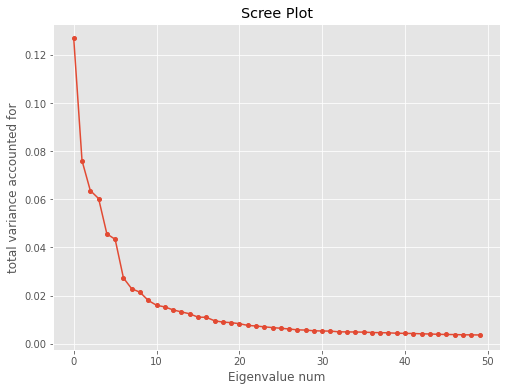

In [71]:
plt.figure(figsize=(8, 6))
plt.style.use("ggplot") 
plt.plot(pca_fitted.explained_variance_ratio_[:50], marker='o', markersize=4)
plt.ylabel("total variance accounted for")
plt.xlabel("Eigenvalue num")
plt.title("Scree Plot")

Text(0.5, 1.0, 'Cummulative Plot')

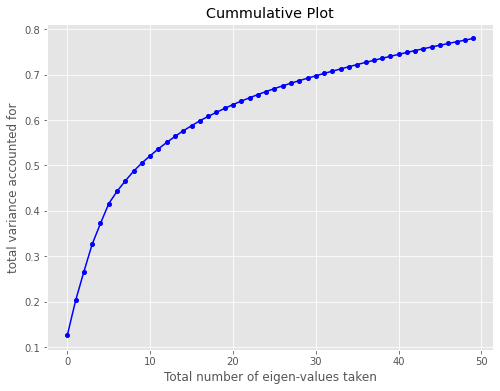

In [72]:
plt.figure(figsize=(8, 6))
plt.style.use("ggplot") 
plt.plot(np.cumsum(pca_fitted.explained_variance_ratio_[:50]), marker='o', markersize=4, color='blue')
plt.ylabel("total variance accounted for")
plt.xlabel("Total number of eigen-values taken")
plt.title("Cummulative Plot")

In [73]:
for i in range(10):
    print(f'variance accounted for by PC{i+1}:', f'{pca_fitted.explained_variance_ratio_[i]*100}%')

variance accounted for by PC1: 12.681171298027039%
variance accounted for by PC2: 7.60437548160553%
variance accounted for by PC3: 6.363096088171005%
variance accounted for by PC4: 6.031755730509758%
variance accounted for by PC5: 4.5627161860466%
variance accounted for by PC6: 4.337796941399574%
variance accounted for by PC7: 2.732940949499607%
variance accounted for by PC8: 2.283361367881298%
variance accounted for by PC9: 2.1393757313489914%
variance accounted for by PC10: 1.796925999224186%


In [74]:
# activations from 1st eigen vector:
activations1 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[0])), axis=3)
# activations from 2nd eigen vector:
activations2 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[1])), axis=3)
# activations from 3rd eigen vector:
activations3 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[2])), axis=3)
# activations from 4th eigen vector:
activations4 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[3])), axis=3)
# activations from 5th eigen vector:
activations5 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[4])), axis=3)
# activations from 6th eigen vector:
activations6 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[5])), axis=3)
# activations from 6th eigen vector:
activations7 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[6])), axis=3)
# activations from 6th eigen vector:
activations8 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[7])), axis=3)
# activations from 6th eigen vector:
activations9 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[8])), axis=3)
# activations from 6th eigen vector:
activations10 = np.sum(np.multiply(activ_maps, np.absolute(pca_fitted.components_[9])), axis=3)

In [75]:
from skimage.transform import rescale

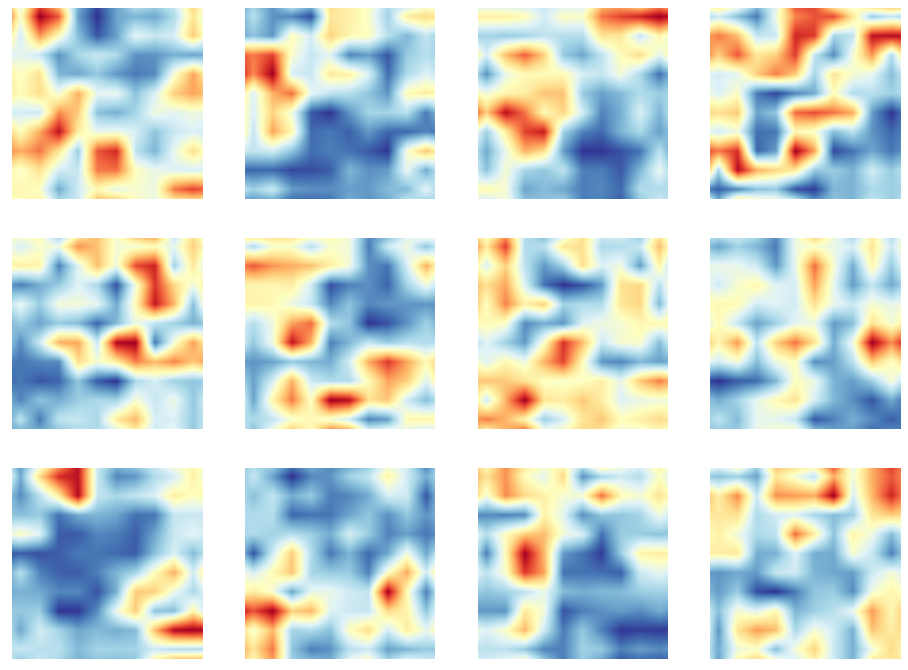

In [76]:
fig1, ax1 = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
for i in range(960//SIZE_Y):
    for j in range(1280//SIZE_X):
        curr_activation = rescale(activations5[(1280//SIZE_X)*i + j], (32, 32))
        ax1[i][j].imshow(curr_activation, cmap='RdYlBu_r')
        ax1[i][j].grid(False)
        ax1[i][j].set_xticks([])
        ax1[i][j].set_yticks([])
plt.show()


In [77]:
total_var = np.sum(pca_fitted.explained_variance_ratio_[0:10])

In [78]:

N = (960*1280)//(SIZE_Y*SIZE_X)
images_placeholder = np.empty((23, 960, 1280))
for i in range(0, activations1.shape[0], N):
    image_patches = (1/total_var)*(activations1[i:i+N]*pca_fitted.explained_variance_ratio_[0]+
                                   activations2[i:i+N]*pca_fitted.explained_variance_ratio_[1]+
                                   activations3[i:i+N]*pca_fitted.explained_variance_ratio_[2]+
                                   activations4[i:i+N]*pca_fitted.explained_variance_ratio_[3]+
                                   activations5[i:i+N]*pca_fitted.explained_variance_ratio_[4]+
                                   activations6[i:i+N]*pca_fitted.explained_variance_ratio_[5]+
                                   activations7[i:i+N]*pca_fitted.explained_variance_ratio_[6]+
                                   activations8[i:i+N]*pca_fitted.explained_variance_ratio_[7]+
                                   activations9[i:i+N]*pca_fitted.explained_variance_ratio_[8]+
                                   activations10[i:i+N]*pca_fitted.explained_variance_ratio_[9])
    image_patches = rescale(image_patches, (1, 32, 32))
    image_patches = image_patches.reshape((960//SIZE_Y, 1280//SIZE_X, SIZE_Y, SIZE_X))
    reconstructed_image = unpatchify(image_patches, (960, 1280))
    images_placeholder[i//N, ...] = reconstructed_image 


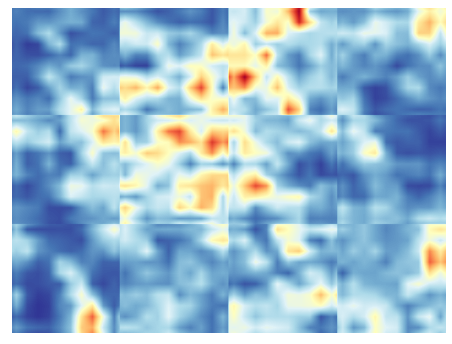

In [83]:
plt.figure(figsize=(8, 6))
plt.imshow(images_placeholder[19], cmap='RdYlBu_r')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/BTP/activations-VGG16-160', images_placeholder)

In [ ]:
# for layer in VGG_model.layers[:15]:
#     layer.trainable = False

# for i, layer in enumerate(VGG_model.layers):
#     print(i, layer.name, layer.trainable)